In [8]:
import sys
import json
import os
import glob
import time
%tensorflow_version 2.x
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import imageio
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical   
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/scripts')

import dcgan, cgan
import inception_score, inception_model

#from inception_score import *
#from inception_model import *
from importlib import reload
dcgan = reload(dcgan)
cgan = reload(cgan)
inception_model = reload(inception_model)
inception_score = reload(inception_score)

tf.__version__

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'2.1.0'

# **Loading and shuffling training data**

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# #normalise data between -1 and 1 (given min is 0 and max is 255)
# x_train_n = 2 * ( x_train - 0 ) / (255 - 0) - 1
# x_test_n = 2 * ( x_test - 0 ) / (255 - 0) - 1

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Create one hot encoding
labels = to_categorical(y_train, num_classes=10)

# Random seed and get shuffled indices
# tf.random.set_seed(80085)
indices = tf.range(start=0, limit=BUFFER_SIZE, dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

x_train = tf.gather(x_train,shuffled_indices)
labels = tf.gather(labels,shuffled_indices)

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE,drop_remainder=True)
train_labels = tf.data.Dataset.from_tensor_slices(labels).batch(BATCH_SIZE,drop_remainder=True)

11493376/11490434 [==============================] - 0s 0us/step


# **Creating and training a model**

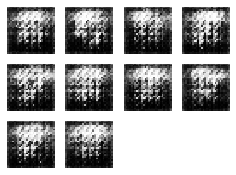

In [100]:
model = dcgan.dcgan(batch_size=BATCH_SIZE, filters=1)
G_loss, D_loss = model.train(train_dataset, train_labels, epochs=25)

Saving model


In [101]:
name = "dcgan_e50_d1_f1_b128_lr5"
tf.saved_model.save(model.G, "/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
tf.saved_model.save(model.D, "/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", G_loss, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", D_loss, delimiter=',')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/dcgan_e50_d1_f1_b128_lr5/G/assets
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/dcgan_e50_d1_f1_b128_lr5/D/assets


# **Testing**

DCGAN testing

In [0]:
name = "dcgan_d1_f3_b128"
loaded = dcgan.dcgan(20,20,BATCH_SIZE)
loaded.G = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
loaded.D = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
loaded_G_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
loaded_D_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')

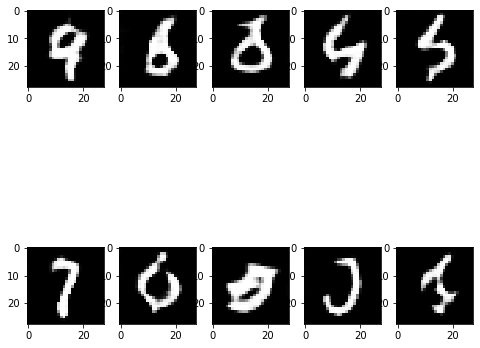

In [53]:
fig = plt.figure(figsize=(8, 8))
for i in range(1,11): 
  noise = tf.random.normal([1,100])
  image = loaded.G(noise,training=False)
  fig.add_subplot(2, 5, i)
  plt.imshow(image[0,:,:,0],cmap='gray')

CGAN testing

In [0]:
name = "cgan_e50_d1_f1"
loaded = cgan.cgan(20,20,BATCH_SIZE)
loaded.G = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/G")
loaded.D = tf.saved_model.load("/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/"+name+"/D")
loaded_G_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
loaded_D_loss = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


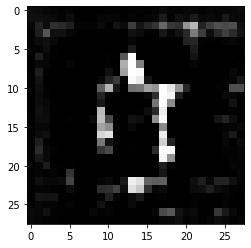

In [0]:
tf.random.set_seed(np.random.randint(1000))
noise = tf.random.normal([1,100])
#np.random.seed(1)
label = to_categorical([9],num_classes=10)

image = model.G([noise,label],training=False)
plt.imshow(image[0,:,:,0],cmap='gray')
print(label)

# **Loss graphs**

Text(0.5, 1.0, 'Discriminator loss')

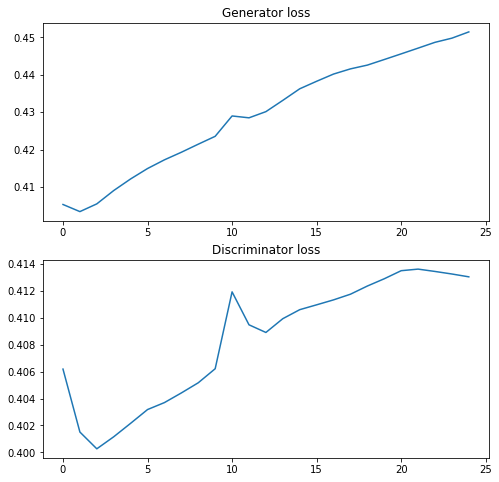

In [103]:
loss_fig = plt.figure(figsize=(8, 8))

loss_fig.add_subplot(2, 1, 1)
plt.plot(loaded_G_loss)
plt.title("Generator loss")

loss_fig.add_subplot(2, 1, 2)
plt.plot(loaded_D_loss)
plt.title("Discriminator loss")

Loading all the model losses

In [0]:
g_losses = {}
d_losses = {}
name = 'dcgan_d1_f1_b128'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')
name = 'dcgan_d1_f1_b64'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')
name = 'dcgan_d1_f1_b32'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')
name = 'dcgan_d1_f2_b128'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')        
name = 'dcgan_d1_f3_b128'
g_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/G_loss.csv", delimiter=',')
d_losses[name] = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/ELEC97052 Selected Topics in Machine Learning/saved_models/'+name+"/D_loss.csv", delimiter=',')        

Plotting all the model losses

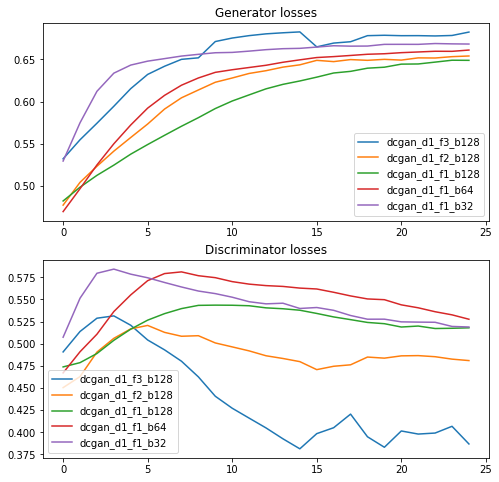

In [6]:
loss_fig = plt.figure(figsize=(8, 8))

loss_fig.add_subplot(2, 1, 1)
plt.plot(g_losses['dcgan_d1_f3_b128'],label = "dcgan_d1_f3_b128")
plt.plot(g_losses['dcgan_d1_f2_b128'],label = "dcgan_d1_f2_b128")
plt.plot(g_losses['dcgan_d1_f1_b128'],label = "dcgan_d1_f1_b128")
plt.plot(g_losses['dcgan_d1_f1_b64'],label = "dcgan_d1_f1_b64")
plt.plot(g_losses['dcgan_d1_f1_b32'],label = "dcgan_d1_f1_b32")
plt.title("Generator losses")
plt.legend()

loss_fig.add_subplot(2, 1, 2)
plt.plot(d_losses['dcgan_d1_f3_b128'],label = "dcgan_d1_f3_b128")
plt.plot(d_losses['dcgan_d1_f2_b128'],label = "dcgan_d1_f2_b128")
plt.plot(d_losses['dcgan_d1_f1_b128'],label = "dcgan_d1_f1_b128")
plt.plot(d_losses['dcgan_d1_f1_b64'],label = "dcgan_d1_f1_b64")
plt.plot(d_losses['dcgan_d1_f1_b32'],label = "dcgan_d1_f1_b32")
plt.title("Discriminator losses")
plt.legend()